# Classification με CNN neural network
- Επιλέχθηκαν 1000 εικόνες από την κάθε κλάση και τοποθετήθηκαν στον αντίστοιχο φάκελο χειροκίνητα, η επιλογή έγινε με βάση τα ελάχιστα δεδομένα που απαιτούσε η εργασία.
- θυμίζω έγιεν ενα χώρισμα των κλάσεων ανάμεσα σε εμένα (Οδυσσέας) και την Δήμητρα λόγω προβλήματος έλλειψηε labels στα δικά τησ data, όπως είχαμε συζητήσει ακι στο μάθημα.

## Άνοιγμα των φακέλων διαδοχικά και εισαγωγή των εικόνων σε numpy arrays

In [1]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = '/Users/odys/Desktop/ML_LOCAL_MAC/archive_1000pics'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 4000 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']


## Χώρισμα των δεδομένων σε train και test σύνολα.
 

In [2]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (2800, 64, 64), labels: (2800,)
Shape Test set: (1200, 64, 64), labels:(1200,)


## Κανονικοποίηση και label encode για να περάσουμε στο CNN

In [3]:
# --- Preprocessing: Normalize images and encode labels ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize pixel values
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Encode labels to integers, then to one-hot
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

print(f"Classes: {le.classes_}")
print(f"y_train_cat shape: {y_train_cat.shape}")

2025-06-07 16:26:09.478849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Classes: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']
y_train_cat shape: (2800, 4)


##  Δημιουργία CNN
- επιέχθηκε το tensorflow για την διεκπεραίωση μετα από δοκιμές και με το pytorch, απλά προσωπική προτίμιση δεν υπηρχε κάποιο πρόβλημα με το pytorch.
- Η αρχιτεκτονικη του βασικού μοντελου ακολουθησε το παραδειγμα απο το βιβλίο "A. Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, O'Reilly, 2022, p. 312"

In [4]:
# --- Build the CNN model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Expand dims for grayscale images
if len(X_train_norm.shape) == 3:
    X_train_norm = np.expand_dims(X_train_norm, -1)
    X_test_norm = np.expand_dims(X_test_norm, -1)

input_shape = X_train_norm.shape[1:]  # Now should be (64, 64, 1)
num_classes = y_train_cat.shape[1]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/odys/Desktop/ML_LOCAL_MAC/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,092 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## Εκπαίδευση του μοντέλου

In [5]:
# --- Train the model ---
history_non_tunned = model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8300 - loss: 0.4389 - val_accuracy: 0.9964 - val_loss: 0.0104
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9960 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9982 - val_loss: 0.0029
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9946 - val_loss: 0.0178
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9964 - val_loss: 0.0046
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9984 - loss: 0.0064 - val_accuracy: 0.9964 - val_loss: 0.0093
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9986 - loss: 0.0039 - val_accuracy: 0.9946 - val_loss: 0.0117
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9980 - loss: 0.0066 - val_accuracy: 1.0000 -

## Εκτύπωση καμπύης μάθησης 
- σε μορφή συνάρτησης για οικονομία (θα ξαναχρησιμοποιηθεί και μετά)

In [6]:
def plot_learning_curve(history, title_suffix=""):
    """
    Plots the learning curve (accuracy and loss) for a Keras model training history.
    Args:
        history: Keras History object from model.fit().
        title_suffix: Optional string to append to plot titles.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Learning Curve - Accuracy{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curve - Loss{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

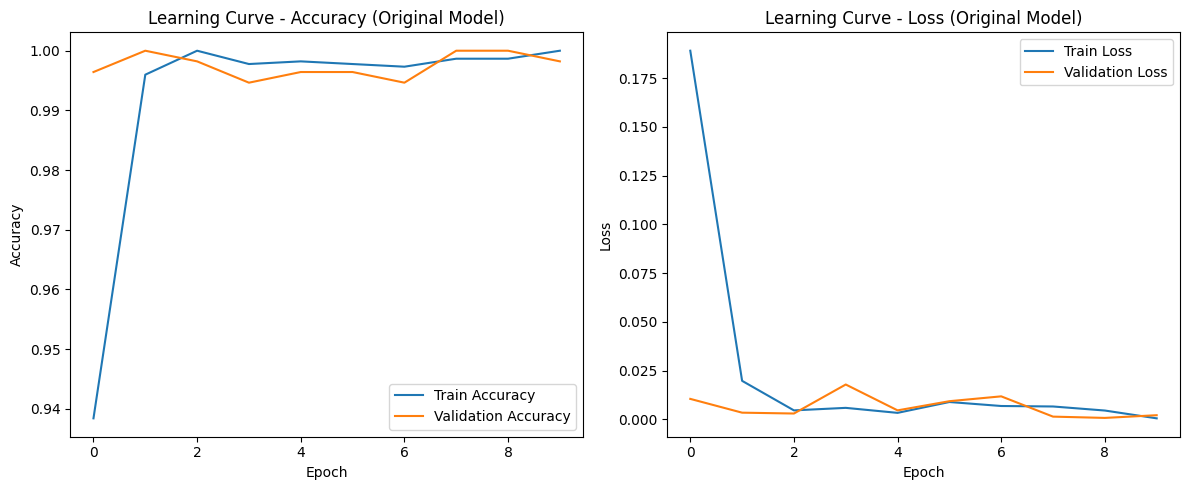

In [7]:
# For non-optimized model
plot_learning_curve(history_non_tunned, title_suffix=" (Original Model)")


## Αξιολόγιση μοντέλου
- confusion matrix 
- classification report 
- ROC curve

In [8]:
def assess_cnn_model(model, X_test, y_test_cat, label_encoder, title_suffix=""):
    """
    Assess a CNN model: prints confusion matrix, classification report, and ROC curves.
    Args:
        model: Trained Keras model.
        X_test: Normalized test images.
        y_test_cat: One-hot encoded test labels.
        label_encoder: Fitted LabelEncoder instance.
        title_suffix: Optional string to append to plot titles.
    """
    from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Predict class probabilities and convert to class labels
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.show()

    # Classification report
    print(f"Classification Report{title_suffix}:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # ROC Curve for each class
    y_test_bin = label_binarize(y_true, classes=range(len(label_encoder.classes_)))
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Multi-class{title_suffix}')
    plt.legend(loc="lower right")
    plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


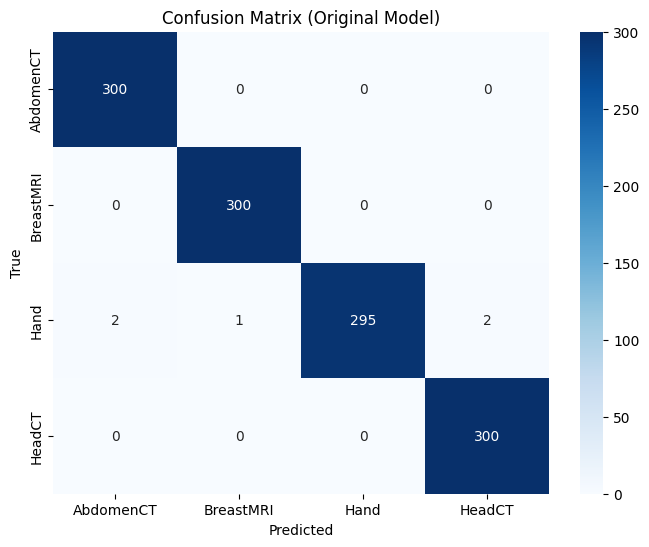

Classification Report (Original Model):
              precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      1.00       300
   BreastMRI       1.00      1.00      1.00       300
        Hand       1.00      0.98      0.99       300
      HeadCT       0.99      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



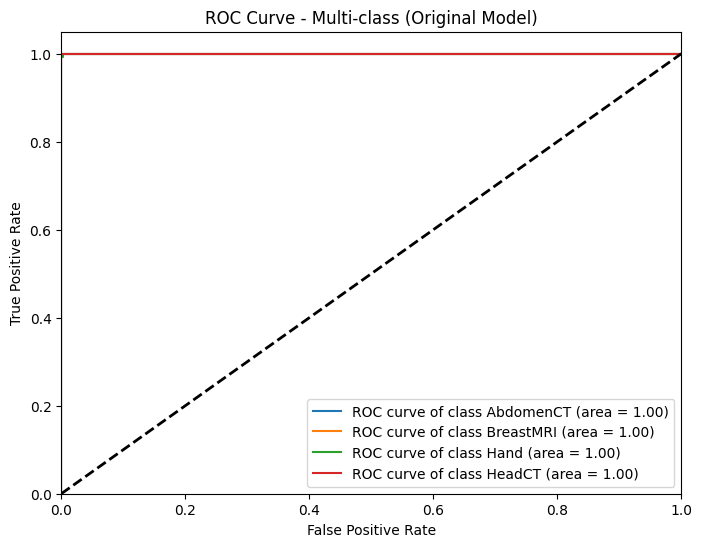

In [9]:
# For non-optimized model
assess_cnn_model(model, X_test_norm, y_test_cat, le, title_suffix=" (Original Model)")


## Έυρεση βέλτιστων παραμέτρων με την χρήση Keras tunner
- Τα αποτελέσματα ακόμα και πρίν την χρήσηη του ήταν εξαιρετικά, επομένω δεν διακιολογεί η επιλογή χρήσης του το υπολογιστικό του φορτίο.

In [10]:
# --- Hyperparameter tuning with Keras Tuner ---
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning'
)

tuner.search(
    X_train_norm, y_train_cat,
    epochs=5,
    validation_split=0.2,
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hp.values.keys():
    print(f"{param}: {best_hp.get(param)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hp)
history_tunned = best_model.fit(
    X_train_norm, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Reloading Tuner from kt_dir/cnn_tuning/tuner0.json
Best hyperparameters:
conv_1_filters: 32
conv_2_filters: 128
dense_units: 128
dropout: 0.6000000000000001
learning_rate: 0.001
Epoch 1/10


/Users/odys/Desktop/ML_LOCAL_MAC/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.8068 - loss: 0.4756 - val_accuracy: 0.9964 - val_loss: 0.0095
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9950 - loss: 0.0163 - val_accuracy: 0.9964 - val_loss: 0.0132
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9961 - loss: 0.0209 - val_accuracy: 0.9964 - val_loss: 0.0167
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9943 - loss: 0.0269 - val_accuracy: 0.9982 - val_loss: 0.0021
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9993 - loss: 0.0046 - val_accuracy: 0.9982 - val_loss: 0.0054
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9999 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 6.2105e-04
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9964 - val_loss: 0.0108
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9982 

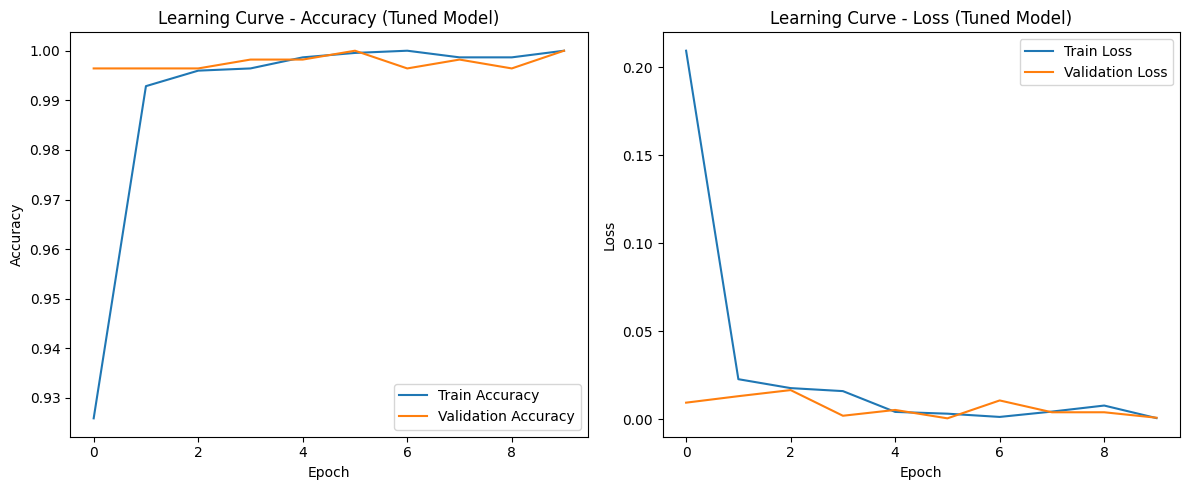

In [ ]:
# For tuned model
plot_learning_curve(history_tunned, title_suffix=" (Tuned Model)")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


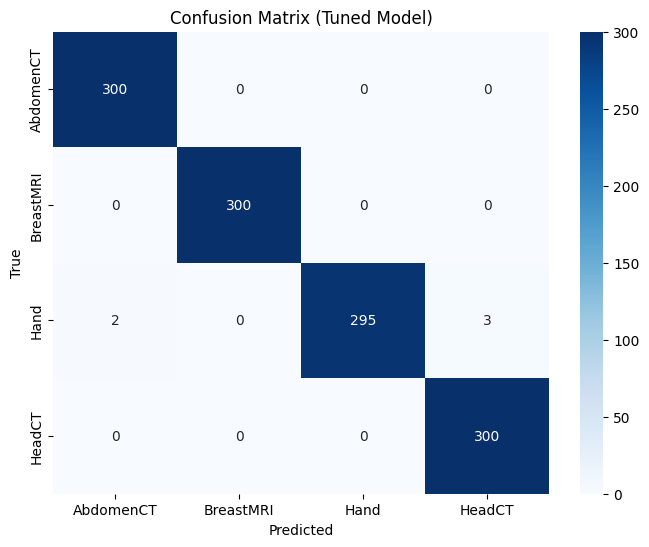

Classification Report (Tuned Model):
              precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      1.00       300
   BreastMRI       1.00      1.00      1.00       300
        Hand       1.00      0.98      0.99       300
      HeadCT       0.99      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



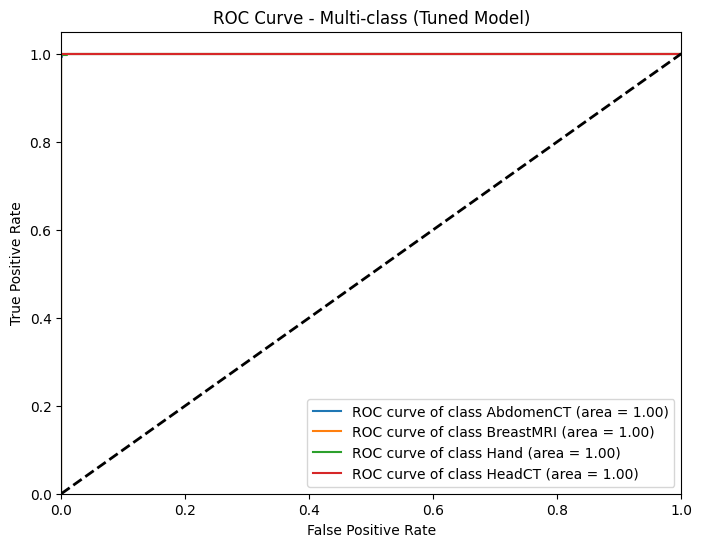

In [ ]:
# For tuned model
assess_cnn_model(best_model, X_test_norm, y_test_cat, le, title_suffix=" (Tuned Model)")

## Δοκιμή διαφορετικών  configurations (παρότι έχουμε ήδη εξαιρετικά αποτελέσματα) από ερευνητική περιέργεια.

In [13]:
import tensorflow as tf

def build_cnn_model(input_shape, num_classes, conv1_filters=32, conv2_filters=64, dense_units=128, dropout_rate=0.5):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(conv1_filters, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(conv2_filters, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example configurations to test
configs = [
    {'conv1_filters': 32, 'conv2_filters': 64, 'dense_units': 128, 'dropout_rate': 0.5},
    {'conv1_filters': 64, 'conv2_filters': 128, 'dense_units': 256, 'dropout_rate': 0.3},
    {'conv1_filters': 16, 'conv2_filters': 32, 'dense_units': 64, 'dropout_rate': 0.7},
]

results = []
for i, cfg in enumerate(configs):
    print(f"\nTraining configuration {i+1}: {cfg}")
    model = build_cnn_model(input_shape, num_classes, **cfg)
    history = model.fit(
        X_train_norm, y_train_cat,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    val_acc = max(history.history['val_accuracy'])
    results.append({'config': cfg, 'val_accuracy': val_acc})

# Print results
for res in results:
    print(f"Config: {res['config']}, Best Validation Accuracy: {res['val_accuracy']:.4f}")

    
# Print results
for res in results:
    print(f"Config: {res['config']}, Best Validation Accuracy: {res['val_accuracy']:.4f}")




Training configuration 1: {'conv1_filters': 32, 'conv2_filters': 64, 'dense_units': 128, 'dropout_rate': 0.5}


/Users/odys/Desktop/ML_LOCAL_MAC/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training configuration 2: {'conv1_filters': 64, 'conv2_filters': 128, 'dense_units': 256, 'dropout_rate': 0.3}

Training configuration 3: {'conv1_filters': 16, 'conv2_filters': 32, 'dense_units': 64, 'dropout_rate': 0.7}
Config: {'conv1_filters': 32, 'conv2_filters': 64, 'dense_units': 128, 'dropout_rate': 0.5}, Best Validation Accuracy: 1.0000
Config: {'conv1_filters': 64, 'conv2_filters': 128, 'dense_units': 256, 'dropout_rate': 0.3}, Best Validation Accuracy: 1.0000
Config: {'conv1_filters': 16, 'conv2_filters': 32, 'dense_units': 64, 'dropout_rate': 0.7}, Best Validation Accuracy: 0.9982
Config: {'conv1_filters': 32, 'conv2_filters': 64, 'dense_units': 128, 'dropout_rate': 0.5}, Best Validation Accuracy: 1.0000
Config: {'conv1_filters': 64, 'conv2_filters': 128, 'dense_units': 256, 'dropout_rate': 0.3}, Best Validation Accuracy: 1.0000
Config: {'conv1_filters': 16, 'conv2_filters': 32, 'dense_units': 64, 'dropout_rate': 0.7}, Best Validation Accuracy: 0.9982


## Εκτύωση αποτελεσμάτων (accuracy) των 3  configurations  που ελέχθηκαν.
- και τα 3 έχουν εξαιρετικά αποτελέσματα

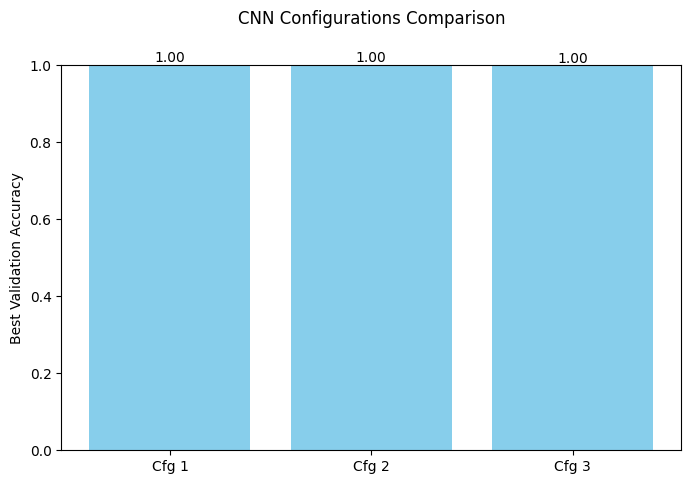

In [20]:
# Plot the results
import matplotlib.pyplot as plt

labels = [f"Cfg {i+1}" for i in range(len(results))]
accuracies = [res['val_accuracy'] for res in results]

plt.figure(figsize=(8,5))
plt.bar(labels, accuracies, color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Best Validation Accuracy')
plt.title('CNN Configurations Comparison', pad=30)  # Move title higher
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()